In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
# To ensure our src module can be found and imported
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import subprocess
import time
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

from src.data.binance_downloader import (
    download_historical_daily_klines,
    generate_latest_historical_df,
    get_realtime_klines,
)
from src.features.feature_generator import (
    feature_pipeline_v1
)

from src.models.metrics import (
    get_metrics
)

from src.visualization.plot_generator import (
    plot_actual_and_predicted_price
)

RANDOM_SEED = 420

{'serverTime': 1673326177110}


In [5]:
DATA_DIR = Path.cwd().parent / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'
PROCESSED_DATA_DIR = DATA_DIR / 'processed'

MODEL_DIR = Path.cwd().parent / 'models'

BINANCE_HISTORICAL_DATA_DIR = RAW_DATA_DIR / 'binance_historical'
BINANCE_HISTORICAL_FILES_DIR = BINANCE_HISTORICAL_DATA_DIR / 'data/spot/daily/klines/BTCUSDT/1m'
BINANCE_HISTORICAL_DF_PATH = PROCESSED_DATA_DIR / 'binance_historical_df.csv'
BINANCE_PROCESSED_DF_PATH = PROCESSED_DATA_DIR / 'binance_processed_df.csv'
TRAIN_DF_PATH = PROCESSED_DATA_DIR / 'binance_train_df.csv'
VAL_DF_PATH = PROCESSED_DATA_DIR / 'binance_val_df.csv'
TEST_DF_PATH = PROCESSED_DATA_DIR / 'binance_test_df.csv'

TRADING_TYPE = 'spot'
TICKER_SYMBOL = 'BTCUSDT'
INTERVAL = '1m'
# No available data before 2021-03-01
START_DATE = '2021-03-01'
END_DATE = (datetime.utcnow() - timedelta(days=1) ).strftime('%Y-%m-%d')
# Reference: https://github.com/binance/binance-public-data/tree/master
RAW_DF_HEADERS = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'num_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']

# Ensure directories are present
BINANCE_HISTORICAL_DATA_DIR.mkdir(parents=True, exist_ok=True)

MA_WINDOW_SIZES_DICT = {
    "close_5m_ma": 5,
    "close_30m_ma": 30,
    "close_1h_ma": 60,
    "close_4h_ma": 240,
    "close_12h_ma": 720,
    "close_1d_ma": 1440,
    "close_15d_ma": 21600,
    "close_30d_ma": 43200,
}

## Real-time inference

In [8]:
# Load model
model_path = str(MODEL_DIR / 'xgb_baseline.pkl')
with open(model_path, 'rb') as f:
    model_package = pickle.load(f)
    
ohe_encoder = model_package['ohe_encoder']
model = model_package['model']

In [9]:
# Prepare data for inference
# Take data from 30 days ago to support all required feature generation
def generate_inference_df(trading_type,
                          ticker_symbol,
                          interval,
                          start_date,
                          end_date,
                          historical_data_dir,
                          historical_files_dir,
                          small_historical_df_path,
                          raw_df_headers,
                          ohe_encoder,
                          ma_window_sizes_dict
                         ):
    historical_df = generate_latest_historical_df(trading_type, 
                                                  ticker_symbol,
                                                  interval, 
                                                  start_date, 
                                                  end_date, 
                                                  historical_data_dir, 
                                                  historical_files_dir, 
                                                  small_historical_df_path, 
                                                  raw_df_headers,
                                                  write_csv=True
                                                 )
    historical_end_time = int(historical_df.iloc[-1]['close_time'])
    realtime_klines = get_realtime_klines(start_time=historical_end_time + 1, ticker=ticker_symbol, interval=interval)
    realtime_df = pd.DataFrame(realtime_klines, columns=raw_df_headers).apply(pd.to_numeric)
    combined_df = pd.concat([historical_df, realtime_df], axis=0)
    processed_df, ohe_encoder = feature_pipeline_v1(combined_df, ma_window_sizes_dict, lag_max_offset_period=120, ohe_encoder=ohe_encoder)
    
    return processed_df

Found 1 symbols
[1/1] - start download daily BTCUSDT klines 


/Users/jonathanlim/workspace/personal/bitcoin-god/src/visualization/plot_generator.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


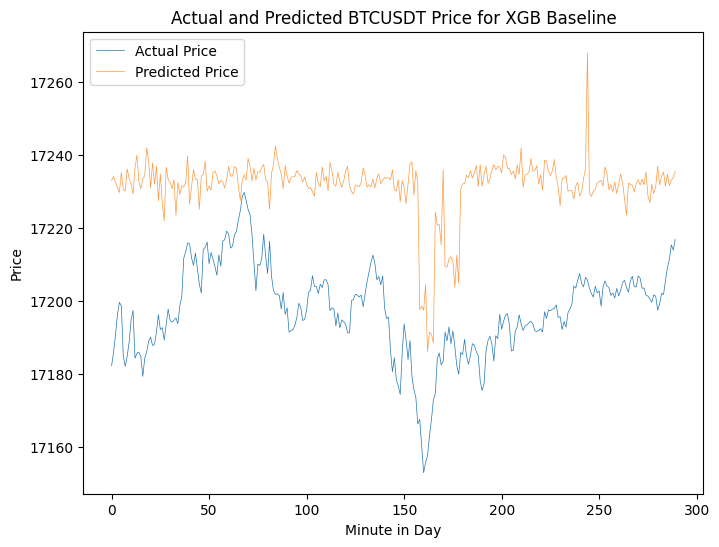

In [10]:
start_date = (datetime.utcnow() - timedelta(days=30) ).strftime('%Y-%m-%d')
end_date = (datetime.utcnow() - timedelta(days=1) ).strftime('%Y-%m-%d')

processed_df = generate_inference_df(
    TRADING_TYPE,
    TICKER_SYMBOL,
    INTERVAL,
    start_date,
    end_date,
    BINANCE_HISTORICAL_DATA_DIR,
    BINANCE_HISTORICAL_FILES_DIR,
    str(PROCESSED_DATA_DIR / 'small_historical_for_realtime_df.csv'),
    RAW_DF_HEADERS,
    ohe_encoder,
    MA_WINDOW_SIZES_DICT,
)
inference_X = processed_df.values[:, 1:-1]
inference_Y = processed_df.values[:, -1]
pred_inference_Y = model.predict(inference_X)
plot_actual_and_predicted_price(inference_Y, pred_inference_Y, title="Actual and Predicted BTCUSDT Price for XGB Baseline")

## Calculate profit of trading strategies on the real-time data and predictions

In [11]:
def generate_price_df(actual_Y, pred_Y):
    price_df = pd.DataFrame({'actual': actual_Y, 'predicted': pred_Y})
    price_df['prev_actual'] = price_df['actual'].shift(1)
    price_df = price_df.dropna()
    return price_df

def strategy_1(price_df):
    # Strategy 1: Buy if predicted > prev_actual. Sell on close. Profit = Actual - prev_actual
    total_profit = 0

    for idx, row in price_df.iterrows():
        # Buy (assume entry price is prev_actual) and sell on close
        if row['predicted'] > row['prev_actual']:
            profit = row['actual'] - row['prev_actual']
        total_profit += profit
    
    return round(total_profit, 2)

def strategy_2(price_df):
    # Strategy 2: Buy if predicted > prev_actual. Sell when predicted < buy_price. Profit = sell_price - buy_price
    total_profit = 0
    buy_price = 0
    
    for idx, row in price_df.iterrows():
        # Buy (assume entry price is prev_actual)
        if buy_price == 0 and row['predicted'] > row['prev_actual']:
            buy_price = row['actual']
        # Sell (if previously bought and price is predicted to drop below buy_price)
        elif buy_price > 0 and row['predicted'] < buy_price:
            profit = row['actual'] - buy_price
            # Reset buy_price
            buy_price = 0
            total_profit += profit

    return round(total_profit, 2)

Test out the trading strategies on the latest real-time data

In [12]:
price_df = generate_price_df(inference_Y, pred_inference_Y)
print(f"Strategy 1 yielded: ${strategy_1(price_df)}")
print(f"Strategy 2 yielded: ${strategy_2(price_df)}")

Strategy 1 yielded: $34.57
Strategy 2 yielded: $0


Test out the trading strategies on the test data

In [16]:
test_df = pd.read_csv(TEST_DF_PATH)

test_X = test_df.values[:, 1:-1]
test_Y = test_df.values[:, -1]
pred_test_Y = model.predict(test_X)

test_price_df = generate_price_df(test_Y, pred_test_Y)
print(f"Strategy 1 yielded: ${strategy_1(test_price_df)}")
print(f"Strategy 2 yielded: ${strategy_2(test_price_df)}")

Strategy 1 yielded: $269.52
Strategy 2 yielded: $-8.16
